# Exploratory Data Analysis for Twitter data
* downloaded about 1% one year's total tweets over the whole world (05/2017-04/2018)
* filter tweets and keep those written in English and is geo-tagged (either with a point coordinate or a rough region)
* about 6,800,000 tweets in total
* extract geographic coordinate and local time
* run a sentiment analysis to get the sentiment of each tweet
* will need to further filter the tweets by only looking at the continental US
* will aggregate the data into temporal and regional means

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

from matplotlib.colors import LinearSegmentedColormap
from geopy.geocoders import Nominatim
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 144
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

## Read data

In [2]:
path='../data/'
df=pd.read_csv('{}{}.csv'.format(path,'201705'),header=0,index_col=0)
for st_append in ['201706','201707','201708','201709','201710','201711','201712','201801','201802','201803','201804']:
    df=pd.concat([df,pd.read_csv('{}{}.csv'.format(path,st_append),header=0,index_col=0)])
df=df.drop_duplicates(subset='id')
a= (df['year']==2017) & (df['month']==4) & (df['day']==30)
df=df[[not x for x in a]]

print("the total number of tweets are: {}".format(len(df)))
print("the  number of tweets talking about weather/climate are: {}".format(len(df[df['weather']|df['climate']])))
df.head()

the total number of tweets are: 6813636
the  number of tweets talking about weather/climate are: 53328


,lon,lat,type,id,sentiment,climate,hurricane,weather,year,month,day,hour,minute
0,-122.232,47.960,polygon,860197174147112961,0.07222,False,False,False,2017,5,4,11,19
1,-80.087,41.160,polygon,860197174143070208,0.15028,False,False,False,2017,5,4,14,19
2,-75.079,40.254,point,860197182544027648,0.03889,False,False,False,2017,5,4,14,19
3,106.765,-6.116,polygon,860197182514667521,0.05346,False,False,False,2017,5,5,1,19
4,-46.855,-23.649,polygon,860197186700804096,0.00833,False,False,False,2017,5,4,15,19


## Where are they?

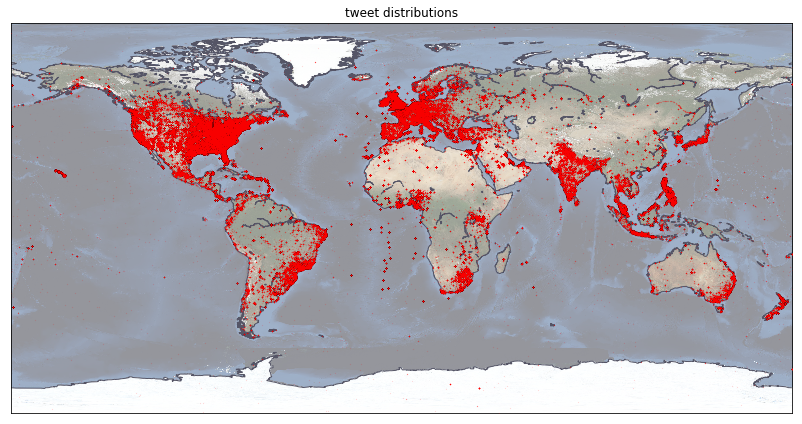

In [3]:
#location of all tweets from 05/2017 to 04/2018
plt.figure(figsize=(14, 8))
earth = Basemap(resolution='l')
_=earth.bluemarble(alpha=0.42)
_=earth.drawcoastlines(color='#555566', linewidth=1)
_=plt.scatter(df['lon'].values, df['lat'].values, s=0.01,
            c='red',alpha=0.5, zorder=10)
_=plt.title('tweet distributions')

In [4]:
#location of cities
geolocator = Nominatim(user_agent="my-application")
cities = ["Chicago","Boston","New York","San Francisco","Houston",
          "Los Angeles","Washington DC","Detroit","Dallas","Indianapolis"]
city_locs=[]
for city in cities:
    city_locs.append(geolocator.geocode(city))

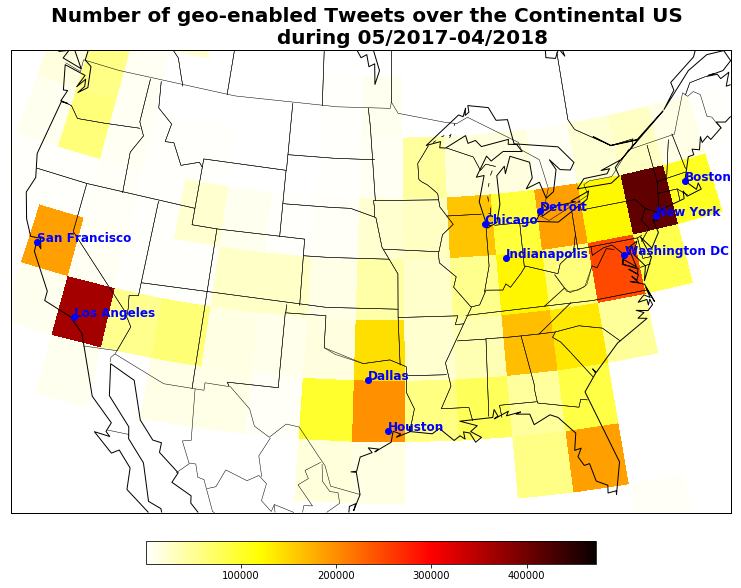

In [5]:
fig=plt.figure(figsize=(10,20))
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.bluemarble(alpha=0.42)

_=m.drawstates()
_=m.drawcountries()
_=m.drawcoastlines()
#_=m.fillcontinents(color='coral',lake_color='aqua')
#_=m.drawparallels(np.arange(-90.,91.,30.))
#_=m.drawmeridians(np.arange(-180.,181.,60.))
_=m.drawmapboundary(fill_color='grey')

lon=df['lon'].values
lat=df['lat'].values
x,y= m(lon, lat)

#m.plot(x,y, 'bo', markersize=5)


db = 1 # bin padding
lon_bins = np.linspace(min(lon)-db, max(lon)+db, 100+1) # 10 bins
lat_bins = np.linspace(min(lat)-db, max(lat)+db, 50+1) # 13 bins
    
density, _, _ = np.histogram2d(lat, lon, [lat_bins, lon_bins])

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
xs, ys = m(lon_bins_2d, lat_bins_2d)

palette = plt.cm.hot_r
plt.pcolormesh(xs, ys, density,cmap=palette,vmin=1)

for city,loc in zip(cities,city_locs):
    x, y = m(loc.longitude, loc.latitude)
    m.plot(x,y,marker='o',color='blue')
    plt.text(x+1000, y, city,fontsize=12,fontweight='bold',color='blue',ha='left')


cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
my_title=r"""Number of geo-enabled Tweets over the Continental US 
            during 05/2017-04/2018"""
plt.title(my_title,fontsize=20,fontweight='bold')
plt.show()

## sentiment
### all tweets

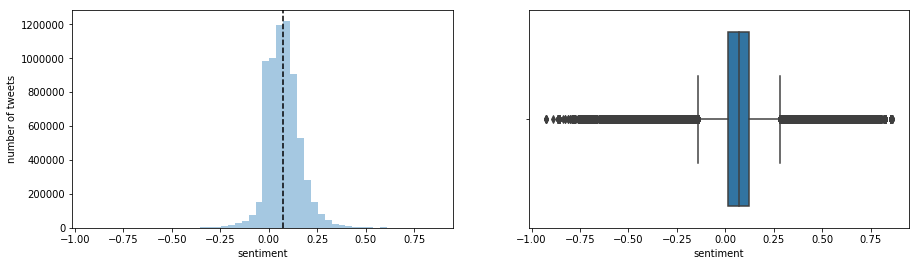

In [21]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
sns.distplot(df['sentiment'].values,kde=False,ax=ax[0])
ax[0].axvline(df['sentiment'].median(), color="k", linestyle="--");
_=ax[0].set_xlabel('sentiment')
_=ax[0].set_ylabel('number of tweets')

_=sns.boxplot(x=df['sentiment'],ax=ax[1])
_=ax[1].set_xlabel('sentiment')

In [73]:
daily_avg_df=df.groupby(['year','month','day'])['sentiment'].agg(['mean']).reset_index().sort_values(by=['year','month','day'])
print('Top 10 Happiest Days')
daily_avg_df.sort_values(by='mean',ascending=False).head(10)

Top 10 Happiest Days


,year,month,day,mean
284,2018,2,14,0.086897
233,2017,12,25,0.086364
202,2017,11,19,0.081908
232,2017,12,24,0.081854
48,2017,6,18,0.080799
92,2017,8,1,0.080492
355,2018,4,26,0.080435
47,2017,6,17,0.080265
62,2017,7,2,0.080088
69,2017,7,9,0.079904


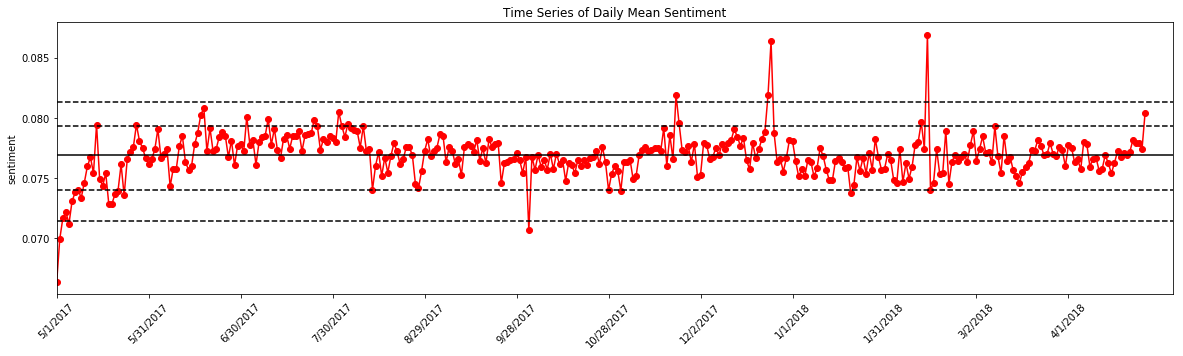

In [52]:
fig,ax=plt.subplots(figsize=(20,5))
_=plt.plot(daily_avg_df['mean'].values,c='red',marker='o')

labels=["{}/{}/{}".format(int(daily_avg_df.iloc[i]['month']),int(daily_avg_df.iloc[i]['day']),int(daily_avg_df.iloc[i]['year'])) 
        for i in range(len(daily_avg_df))]
_=plt.xticks(range(len(daily_avg_df))[::30],labels[::30],rotation=45)
_=plt.ylabel('sentiment')

p1=np.percentile(daily_avg_df['mean'].values, 1)
p99=np.percentile(daily_avg_df['mean'].values, 99)
p5=np.percentile(daily_avg_df['mean'].values, 5)
p95=np.percentile(daily_avg_df['mean'].values, 95)
p50=np.percentile(daily_avg_df['mean'].values, 50)


_=plt.plot([0,364],[p1,p1],'--',c='black')
_=plt.plot([0,364],[p99,p99],'--',c='black')
_=plt.plot([0,364],[p5,p5],'--',c='black')
_=plt.plot([0,364],[p95,p95],'--',c='black')
_=plt.plot([0,364],[p50,p50],'-',c='black')


_=plt.xlim([0,364])
_=plt.title('Time Series of Daily Mean Sentiment')

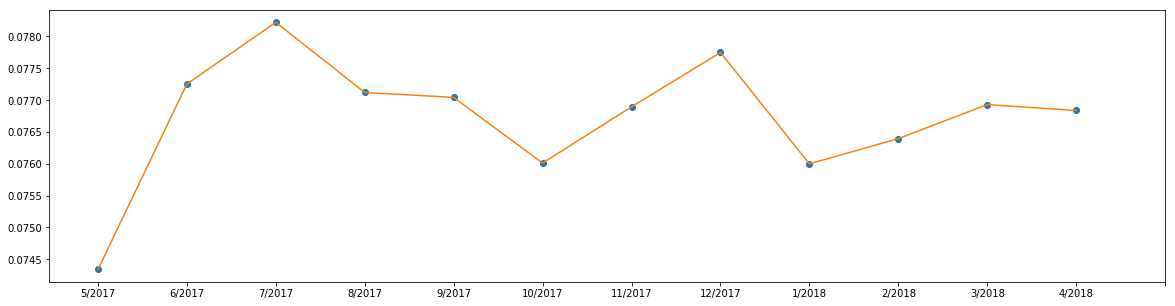

In [61]:
monthly_avg_df=df.groupby(['year','month'])['sentiment'].agg(['mean','std']).reset_index().sort_values(by=['year','month'])
fig,ax=plt.subplots(figsize=(20,5))
_=plt.plot(monthly_avg_df['mean'].values,'o')
_=plt.plot(monthly_avg_df['mean'].values)
#for i in range(len(avg_df)):
#    print(int(avg_df.iloc[i]['year']))
labels=[r"{}/{}".format(int(monthly_avg_df.iloc[i]['month']),int(monthly_avg_df.iloc[i]['year'])) for i in range(len(monthly_avg_df))]
_=plt.xticks(range(0,13),labels)


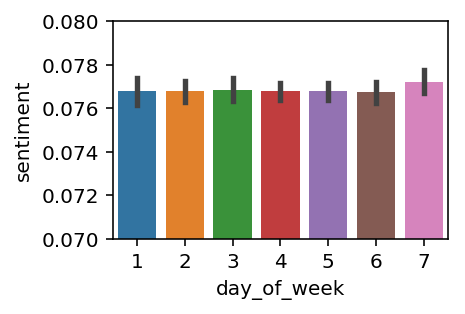

In [90]:
fig,ax=plt.subplots(1,1,figsize=(3,2))
day_of_week=[datetime(int(daily_avg_df.iloc[i]['year']),int(daily_avg_df.iloc[i]['month']),int(daily_avg_df.iloc[i]['day'])).weekday()+1
             for i in range(len(daily_avg_df))]
daily_avg_df['day_of_week']=day_of_week
#daily_avg_df.head()
ax=sns.barplot(x="day_of_week", y="mean", data=daily_avg_df)
_=plt.ylim([0.07,0.08])
_=plt.ylabel('sentiment')

### specific topics: weather or climate related

In [75]:
daily_avg_df_w=df[df['weather']|df['climate']].groupby(['year','month','day'])['sentiment'].agg(['mean']).reset_index().sort_values(by=['year','month','day'])
print('Top 10 happiest days with weather')
daily_avg_df_w.sort_values(by='mean',ascending=False).head(10)

Top 10 happiest days with weather


,year,month,day,mean
29,2017,5,30,0.103644
97,2017,8,6,0.102157
281,2018,2,13,0.098567
86,2017,7,26,0.097438
247,2018,1,9,0.095656
293,2018,2,25,0.094137
294,2018,2,26,0.093696
43,2017,6,13,0.092874
84,2017,7,24,0.092718
248,2018,1,10,0.091682


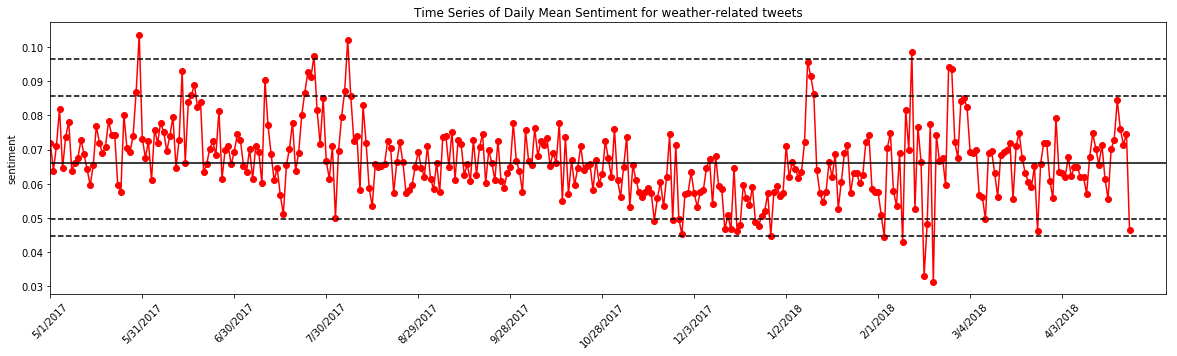

In [54]:
fig,ax=plt.subplots(figsize=(20,5))
_=plt.plot(daily_avg_df_w['mean'].values,c='red',marker='o')

labels=["{}/{}/{}".format(int(daily_avg_df_w.iloc[i]['month']),int(daily_avg_df_w.iloc[i]['day']),int(daily_avg_df_w.iloc[i]['year'])) 
        for i in range(len(daily_avg_df_w))]
_=plt.xticks(range(len(daily_avg_df_w))[::30],labels[::30],rotation=45)
_=plt.ylabel('sentiment')

p1=np.percentile(daily_avg_df_w['mean'].values, 1)
p99=np.percentile(daily_avg_df_w['mean'].values, 99)
p5=np.percentile(daily_avg_df_w['mean'].values, 5)
p95=np.percentile(daily_avg_df_w['mean'].values, 95)
p50=np.percentile(daily_avg_df_w['mean'].values, 50)


_=plt.plot([0,364],[p1,p1],'--',c='black')
_=plt.plot([0,364],[p99,p99],'--',c='black')
_=plt.plot([0,364],[p5,p5],'--',c='black')
_=plt.plot([0,364],[p95,p95],'--',c='black')
_=plt.plot([0,364],[p50,p50],'-',c='black')


_=plt.xlim([0,364])
_=plt.title('Time Series of Daily Mean Sentiment for weather-related tweets')

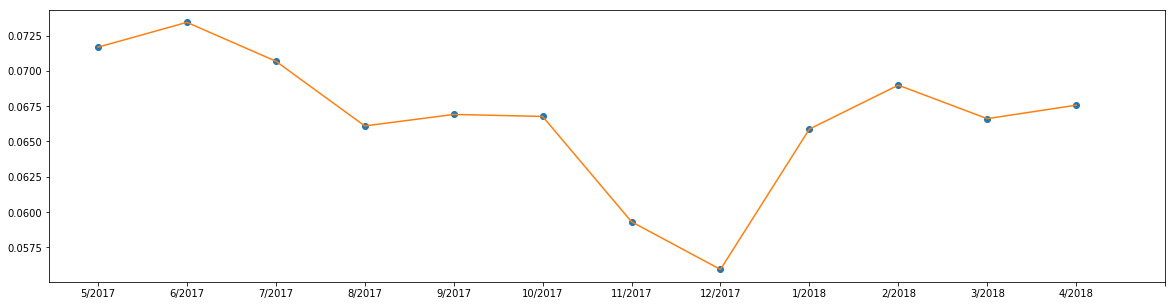

In [59]:
monthly_avg_df_w=df[df['weather']|df['climate']].groupby(['year','month'])['sentiment'].agg(['mean','std']).reset_index().sort_values(by=['year','month'])
fig,ax=plt.subplots(figsize=(20,5))
_=plt.plot(monthly_avg_df_w['mean'].values,'o')
_=plt.plot(monthly_avg_df_w['mean'].values)
labels=[r"{}/{}".format(int(monthly_avg_df_w.iloc[i]['month']),int(monthly_avg_df_w.iloc[i]['year'])) for i in range(len(monthly_avg_df_w))]
_=plt.xticks(range(0,13),labels)



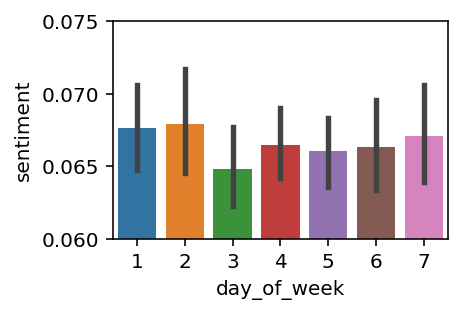

In [91]:
fig,ax=plt.subplots(1,1,figsize=(3,2))
day_of_week=[datetime(int(daily_avg_df_w.iloc[i]['year']),int(daily_avg_df_w.iloc[i]['month']),int(daily_avg_df_w.iloc[i]['day'])).weekday()+1
             for i in range(len(daily_avg_df_w))]
daily_avg_df_w['day_of_week']=day_of_week
#daily_avg_df.head()
ax=sns.barplot(x="day_of_week", y="mean", data=daily_avg_df_w)
_=plt.ylim([0.06,0.075])
_=plt.ylabel('sentiment')

### spatial distribution

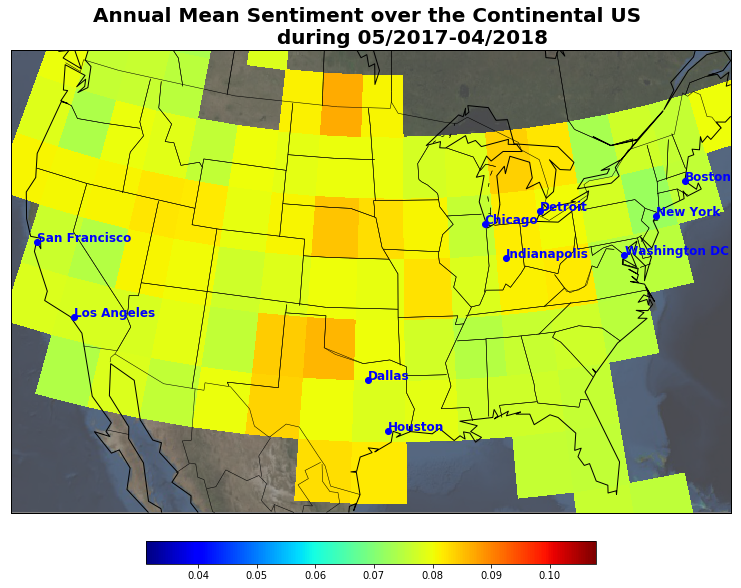

In [72]:
fig=plt.figure(figsize=(10,20))
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.bluemarble(alpha=0.42)

_=m.drawstates()
_=m.drawcountries()
_=m.drawcoastlines()
#_=m.fillcontinents(color='coral',lake_color='aqua')
#_=m.drawparallels(np.arange(-90.,91.,30.))
#_=m.drawmeridians(np.arange(-180.,181.,60.))
_=m.drawmapboundary(fill_color='grey')

lon=df['lon'].values
lat=df['lat'].values
sentiment=df['sentiment'].values
x,y= m(lon, lat)


db = 1 # bin padding
lon_bins = np.linspace(min(lon)-db, max(lon)+db, 100+1) # 10 bins
lat_bins = np.linspace(min(lat)-db, max(lat)+db, 50+1) # 13 bins
    
density, _, _ = np.histogram2d(lat, lon, [lat_bins, lon_bins])
above, _, _ = np.histogram2d(lat, lon, [lat_bins, lon_bins],weights=sentiment)
sentiment_avg=above*np.nan

for i in range(density.shape[0]):
    for j in range(density.shape[1]):
        if density[i,j]>1000:
            sentiment_avg[i,j]=above[i,j]/density[i,j]

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
xs, ys = m(lon_bins_2d, lat_bins_2d)

palette = plt.cm.jet
plt.pcolormesh(xs, ys, sentiment_avg,cmap=palette)

for city,loc in zip(cities,city_locs):
    x, y = m(loc.longitude, loc.latitude)
    m.plot(x,y,marker='o',color='blue')
    plt.text(x+1000, y, city,fontsize=12,fontweight='bold',color='blue',ha='left')


cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
my_title=r"""Annual Mean Sentiment over the Continental US 
            during 05/2017-04/2018"""
plt.title(my_title,fontsize=20,fontweight='bold')
plt.show()

To-do list:
* aggregate sentiment
* download more data